In [5]:
def rastrigin(x, y):
   return  20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

# === Discretization Helper ===
def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(rastrigin, -5, 5, -5, 5, rows, cols)
print(sorted(np.diag(H_C)))

[np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(10.0), np.float64(10.0), np.float64(10.0), np.float64(10.0), np.float64(10.0), np.float64(10.0), np.float64(10.0), np.float64(10.0), np.float64(16.111111111111093), np.float64(16.111111111111093), np.float64(16.111111111111093), np.float64(16.111111111111093), np.float64(16.111111111111143), np.float64(16.111111111111143), np.float64(16.111111111111143), np.float64(16.111111111111143), np.float64(18.0), np.float64(18.0), np.float64(18.0), np.float64(18.0), np.float64(18.77777777777776), np.float64(18.77777777777776), np.float64(18.77777777777776), np.float64(18.77777777777776), np.float64(18.777777777777803), np.float64(18.777777777777803), np.float64(18.777777777777803), np.float64(18.777777777777803), np.float64(21.444444444444418), np.float64(21.444444444444418), np.float64(21.444444444444418), np.float64(21.444444444444418), np.float64(21.44444444444445), np.float64(21.44444444444445), np.float64(21.444

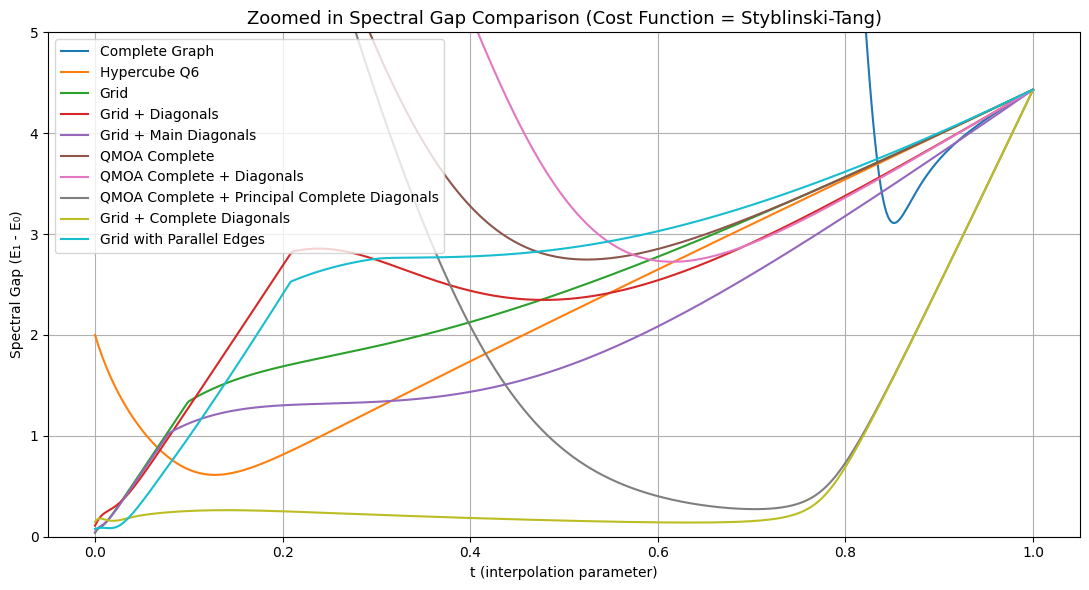

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    return  0.5 * ((x**4 - 16 * x**2 + 5 * x) + (y**4 - 16 * y**2 + 5 * y))

# === Discretization Helper ===
def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -5, 5, -5, 5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q6": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title("Zoomed in Spectral Gap Comparison (Cost Function = Styblinski-Tang)", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

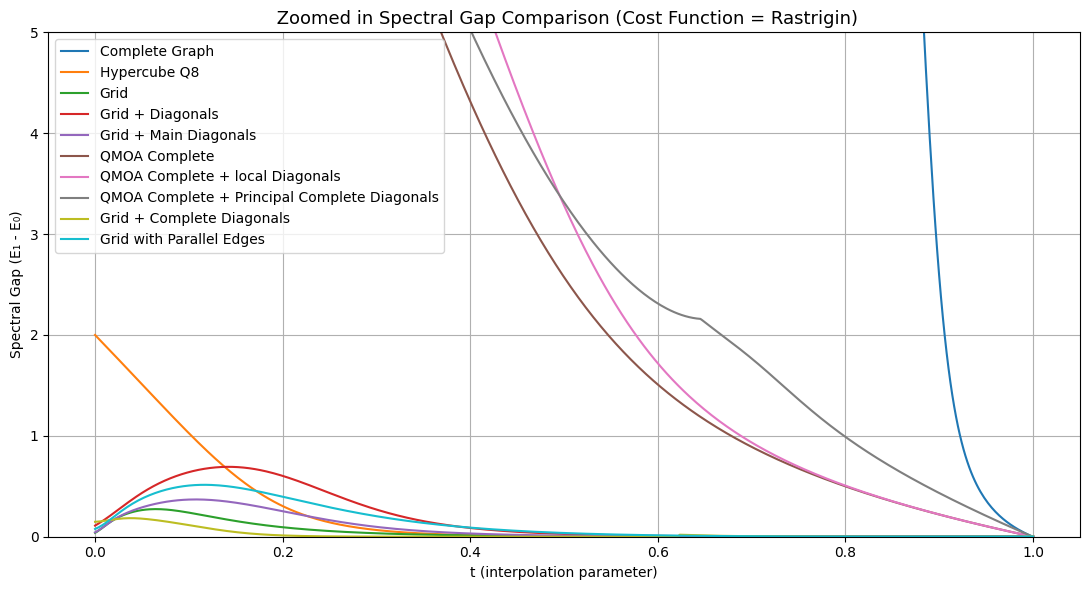

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    return  20 + x**2 + y**2 - 10 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))

# === Discretization Helper ===
def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -4.999, 5, -4.999, 5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Rastrigin)", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

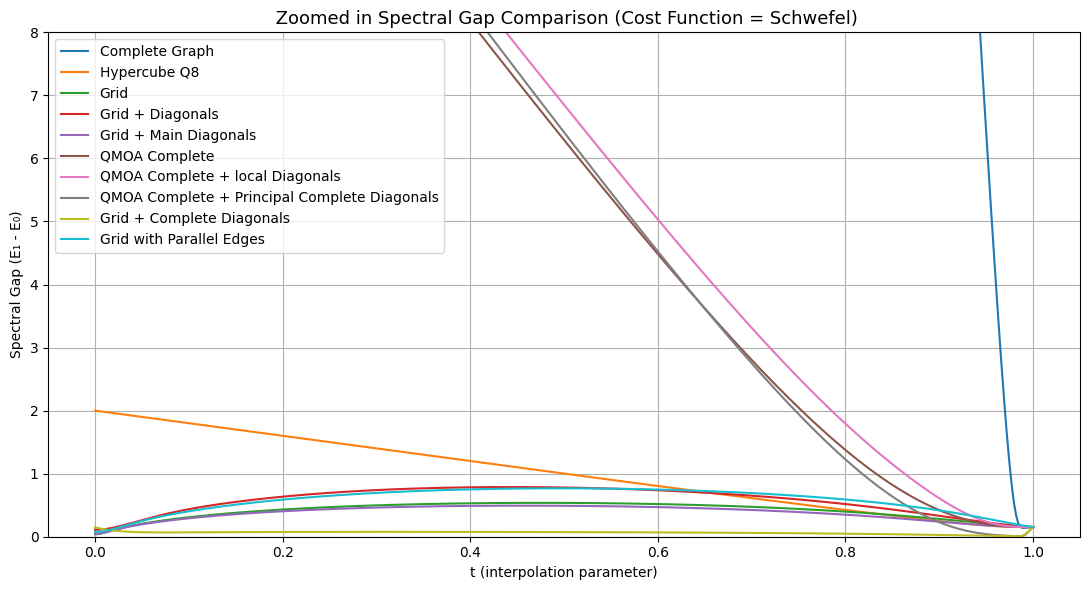

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    return 418.9829*2 - (x*np.sin(np.sqrt(np.abs(x))) + y*np.sin(np.sqrt(np.abs(y))))

def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -5, 5, -5, 5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Schwefel)", fontsize=13)
plt.grid(True)
#plt.xlim(0.8,1)
plt.ylim(0, 8)
plt.legend()
plt.tight_layout()
plt.show()

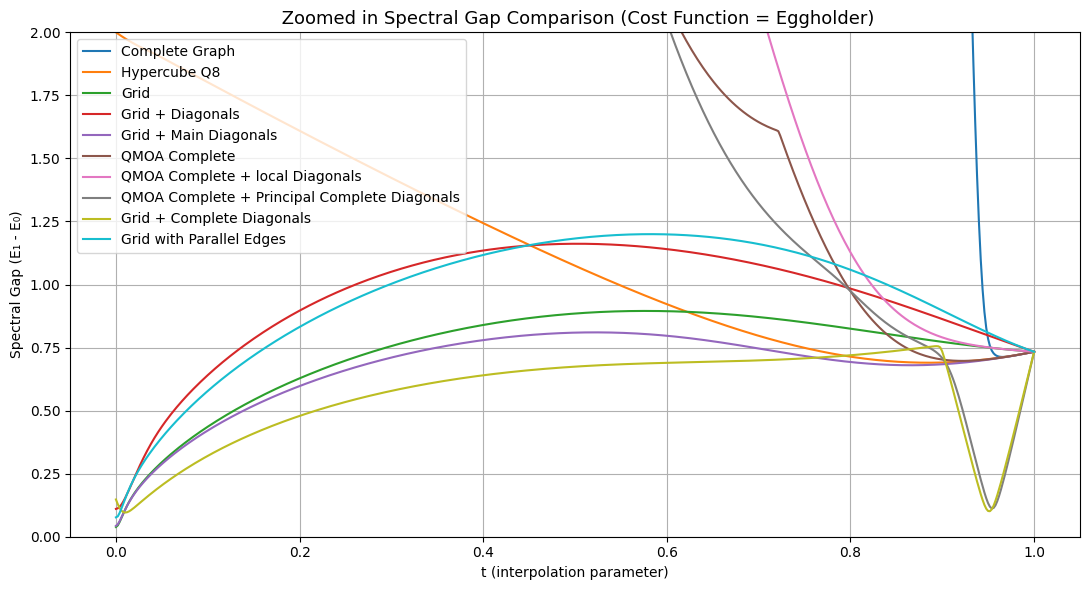

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    return -(y + 47) * np.sin(np.sqrt(abs(x/2 + (y + 47)))) \
           - x * np.sin(np.sqrt(abs(x - (y + 47))))

def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -5, 5, -5, 5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Eggholder)", fontsize=13)
plt.grid(True)
#plt.xlim(0, 1)
plt.ylim(0, 2)
plt.legend()
plt.tight_layout()
plt.show()

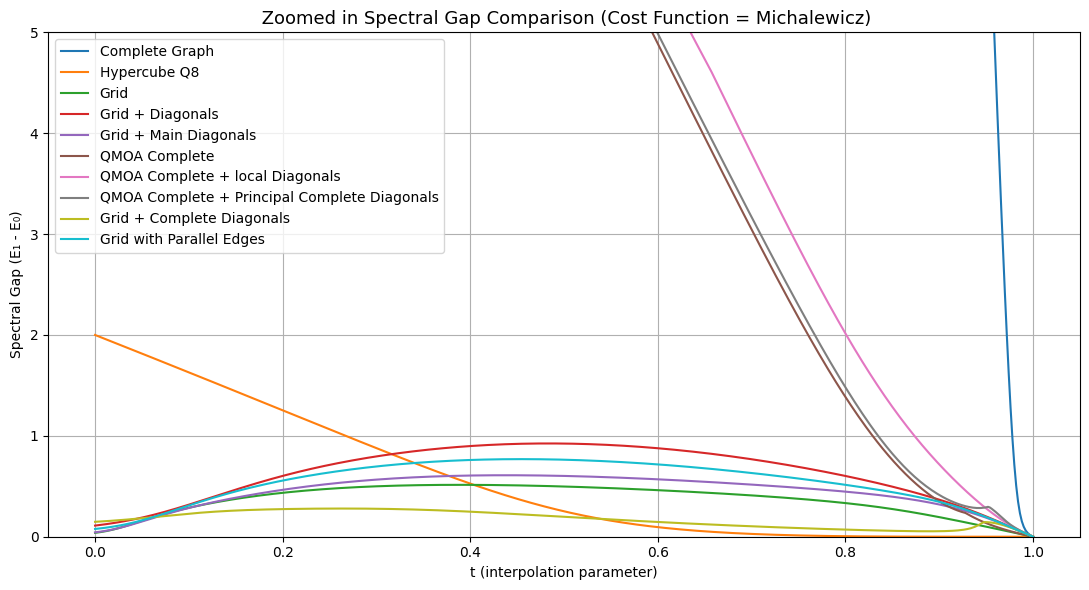

In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x,y, m=10):
    
    term1 = np.sin(x) * (np.sin((x**2)/np.pi) ** (2 * m))
    term2 = np.sin(y) * (np.sin((2 * y**2)/np.pi) ** (2 * m))
    return -(term1 + term2)

# === Discretization Helper ===
def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(ackley, -5, 5, -5, 5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Michalewicz)", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
#plt.xlim(0.8,1)
plt.legend()
plt.tight_layout()
plt.show()

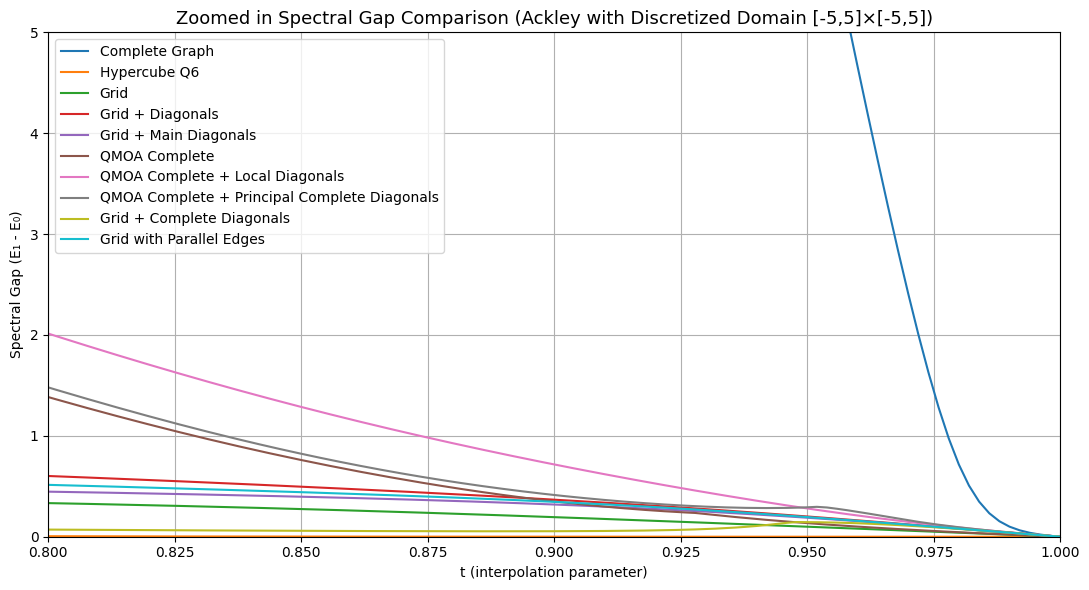

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# === Ackley Cost Function ===
def ackley(x, y):
    a, b, c = 20, 0.2, 2 * np.pi
    x, y = np.array(x), np.array(y)
    sum_sq = 0.5 * (x ** 2 + y ** 2)
    cos_comp = 0.5 * (np.cos(c * x) + np.cos(c * y))
    return -a * np.exp(-b * np.sqrt(sum_sq)) - np.exp(cos_comp) + a + np.exp(1)

# === Discretization Helper ===
def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(ackley, -5, 5, -5, 5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G, ordering="sorted")
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape, f"Mismatch: HQ {H_Q.shape}, HC {H_C.shape}"

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Utility: enforce node count ===
def relabel_and_check(G, n):
    G = nx.convert_node_labels_to_integers(G, ordering="sorted")
    if len(G.nodes) != n:
        raise ValueError(f"Graph has {len(G.nodes)} nodes, expected {n}")
    return G

# === Graph Constructors ===
def build_grid(rows, cols):
    return nx.grid_2d_graph(rows, cols)

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return G

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return G

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return G

def build_qmoa_with_diagonals(rows, cols):
    G = build_qmoa_complete(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return G

def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = build_qmoa_complete(rows, cols)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])
    return G

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])
    return G

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return G_weighted

# === Graph Definitions with safety ===
graphs = {
    "Complete Graph": relabel_and_check(nx.complete_graph(n), n),
    "Hypercube Q6": relabel_and_check(nx.hypercube_graph(8), n),
    "Grid": relabel_and_check(build_grid(rows, cols), n),
    "Grid + Diagonals": relabel_and_check(build_grid_with_diagonals(rows, cols), n),
    "Grid + Main Diagonals": relabel_and_check(build_grid_with_main_diagonals(rows, cols), n),
    "QMOA Complete": relabel_and_check(build_qmoa_complete(rows, cols), n),
    "QMOA Complete + Local Diagonals": relabel_and_check(build_qmoa_with_diagonals(rows, cols), n),
    "QMOA Complete + Principal Complete Diagonals": relabel_and_check(build_qmoa_with_principal_complete_diagonals(rows, cols), n),
    "Grid + Complete Diagonals": relabel_and_check(build_grid_with_complete_diagonals(rows, cols), n),
    "Grid with Parallel Edges": relabel_and_check(multigraph_to_weighted_graph(build_multigraph_grid(rows, cols, edge_multiplicity=2)), n)
}

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title("Zoomed in Spectral Gap Comparison (Ackley with Discretized Domain [-5,5]×[-5,5])", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.xlim(0.8,1)
plt.legend()
plt.tight_layout()
plt.show()

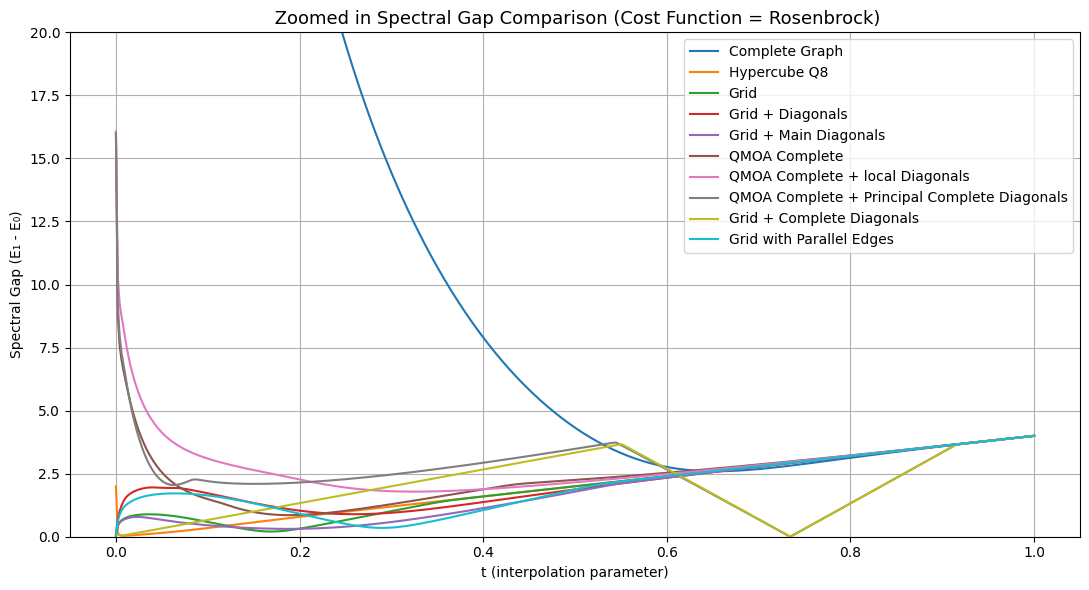

In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y, a=1, b=100):
    return (a - x)**2 + b * (y - x**2)**2

# === Discretization Helper ===
def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -5, 5, -5, 5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Rosenbrock)", fontsize=13)
plt.grid(True)
plt.ylim(0, 20)
#plt.xlim(0.6,1)
plt.legend()
plt.tight_layout()
plt.show()

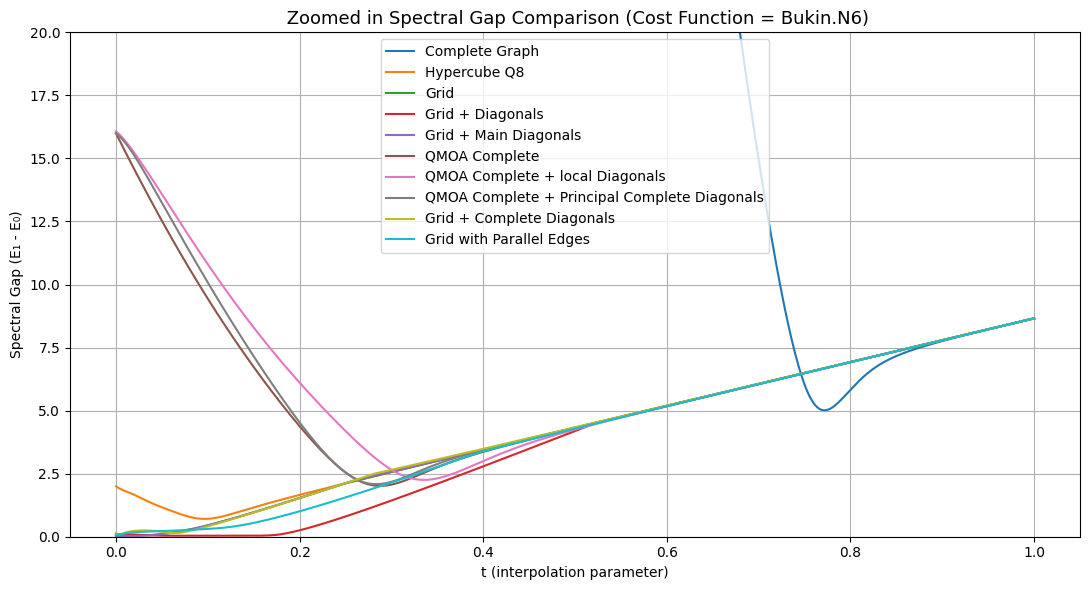

In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    return 100 * np.sqrt(np.abs(y - 0.01 * x**2)) + 0.01 * np.abs(x + 10)

# === Discretization Helper ===
def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn,-15, -5, -3, 3, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Bukin.N6)", fontsize=13)
plt.grid(True)
plt.ylim(0, 20)
#plt.xlim(0.6,1)
plt.legend()
plt.tight_layout()
plt.show()

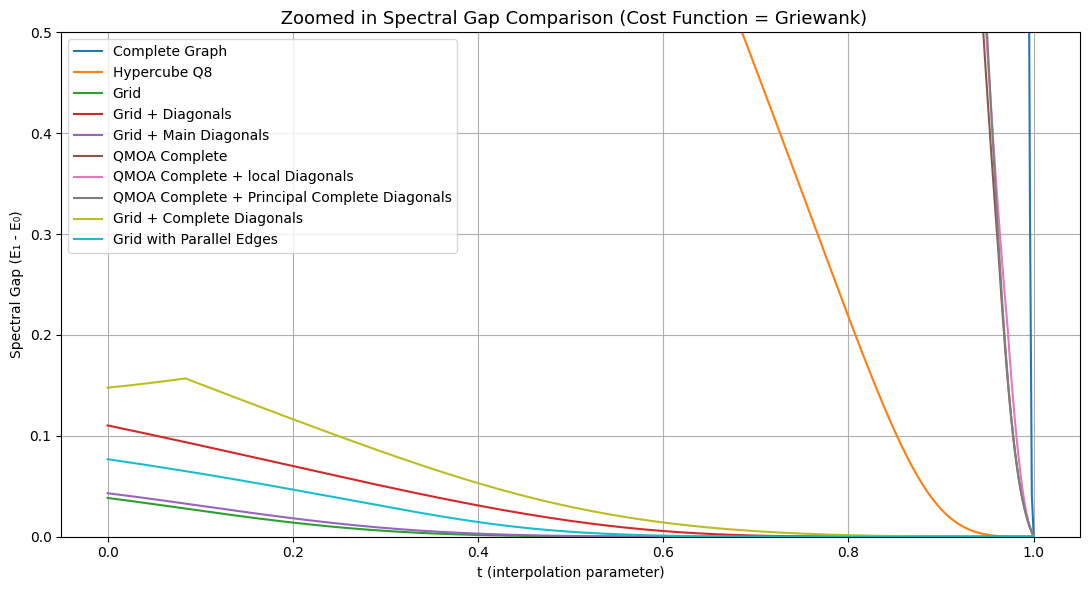

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    term1 = (x**2 + y**2) / 4000
    term2 = np.cos(x / np.sqrt(1)) * np.cos(y / np.sqrt(2))
    return term1 - term2 + 1


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn,-5, 5, -5, 5, rows, cols)


# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Griewank)", fontsize=13)
plt.grid(True)
plt.ylim(0, 0.5)
plt.legend()
plt.tight_layout()
plt.show()

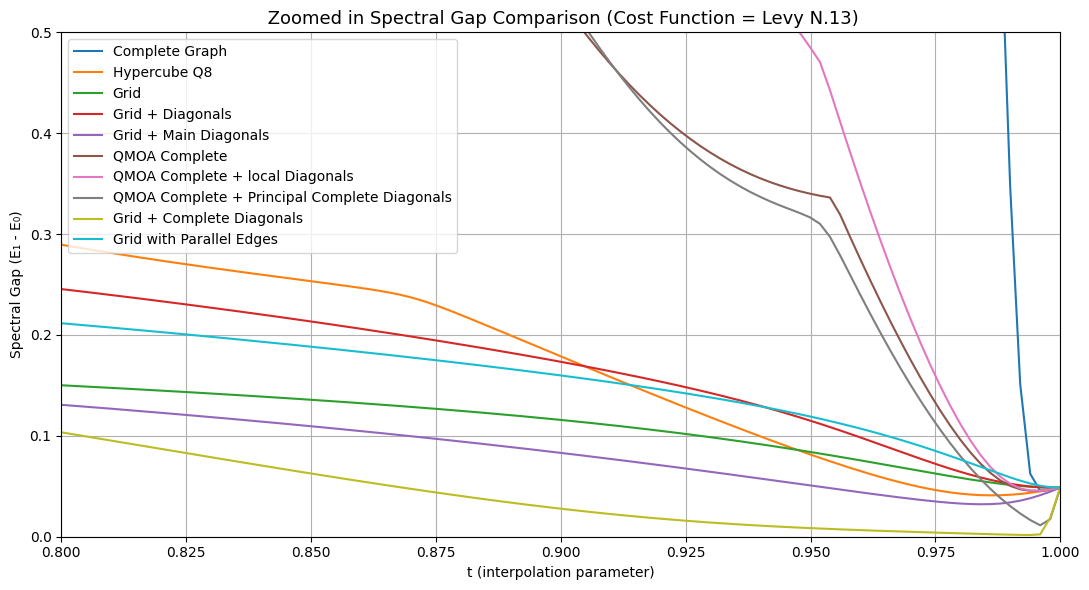

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    w1 = 1 + (x - 1) / 4
    w2 = 1 + (y - 1) / 4
    term1 = np.sin(np.pi * w1) ** 2
    term2 = ((w1 - 1) ** 2) * (1 + 10 * np.sin(np.pi * w1 + 1) ** 2)
    term3 = ((w2 - 1) ** 2) * (1 + np.sin(2 * np.pi * w2) ** 2)
    return term1 + term2 + term3


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn,-5, 5, -5, 5, rows, cols)


# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Levy N.13)", fontsize=13)
plt.grid(True)
plt.ylim(0, 0.5)
plt.xlim(0.8,1)
plt.legend()
plt.tight_layout()
plt.show()

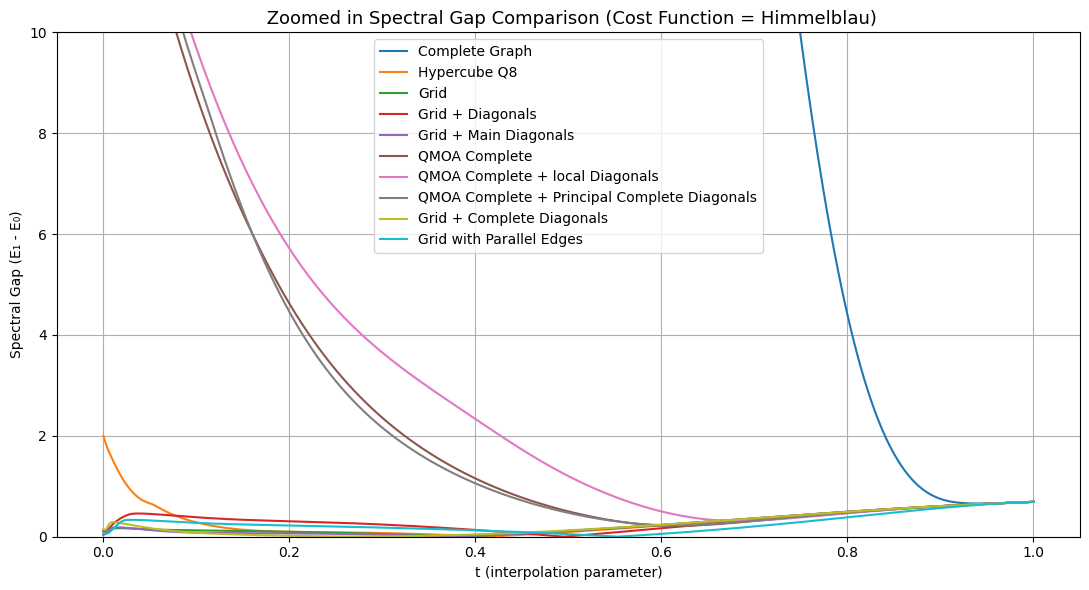

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn,-5, 5, -5, 5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Himmelblau)", fontsize=13)
plt.grid(True)
plt.ylim(0, 10)
plt.legend()
plt.tight_layout()
plt.show()

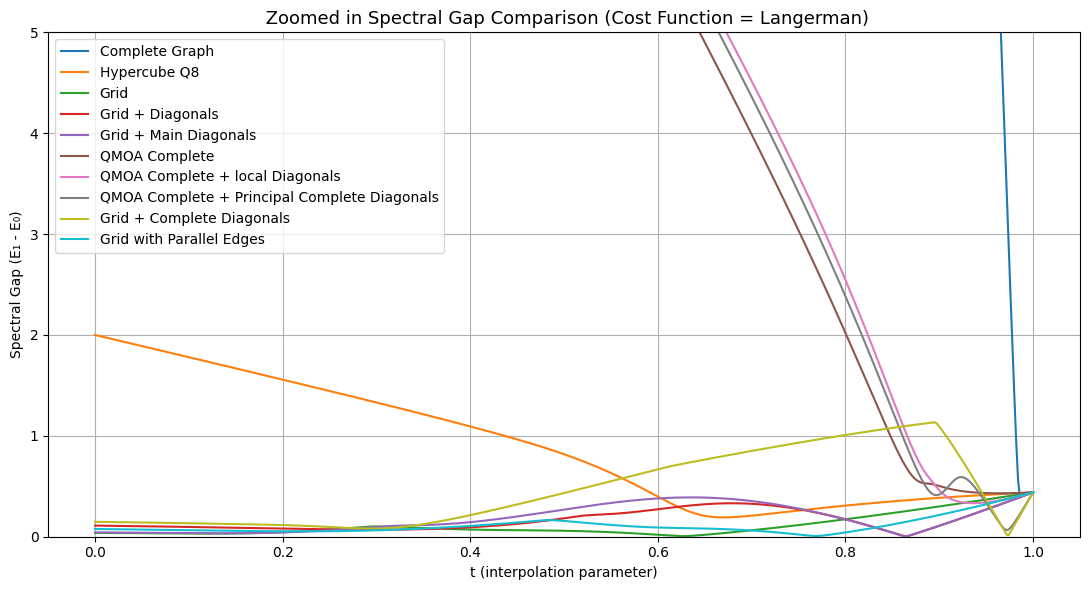

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    a = np.array([3, 5, 2, 1, 7])
    b = np.array([5, 2, 1, 4, 9])
    c = np.array([1, 2, 5, 2, 3])
    m = len(a)

    total = 0
    for i in range(m):
        r2 = (x - a[i])**2 + (y - b[i])**2
        total += c[i] * np.exp(-r2 / np.pi) * np.cos(np.pi * r2)
    return total


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn,0, 10, 0, 10, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Langerman)", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

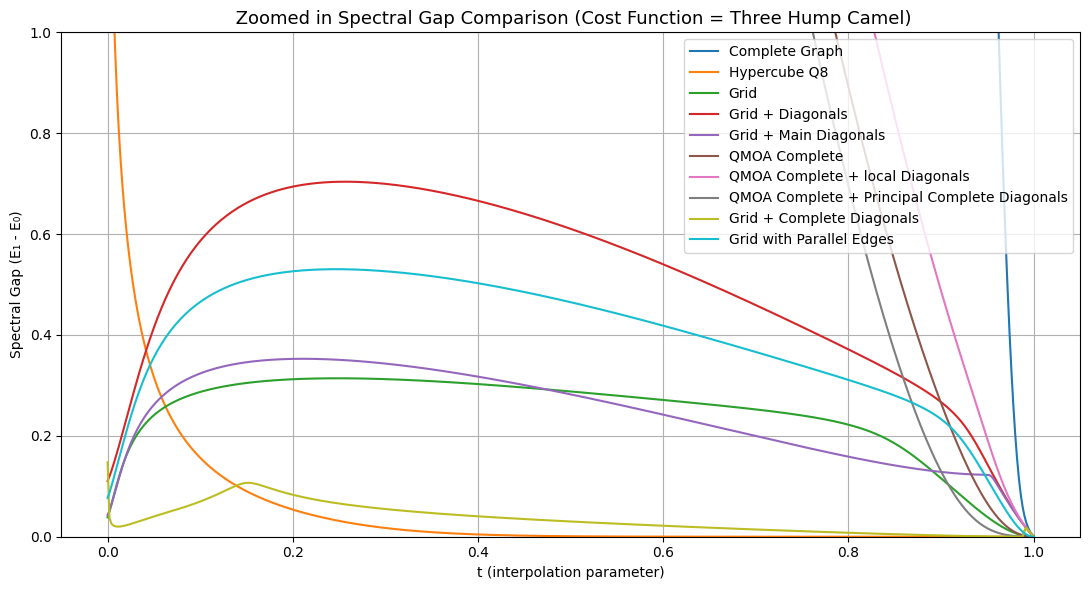

In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    return 2*x**2 - 1.05*(x**4) + (x**6)/6 + x*y + y**2


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn,-5, 5, -5, 5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Three Hump Camel)", fontsize=13)
plt.grid(True)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

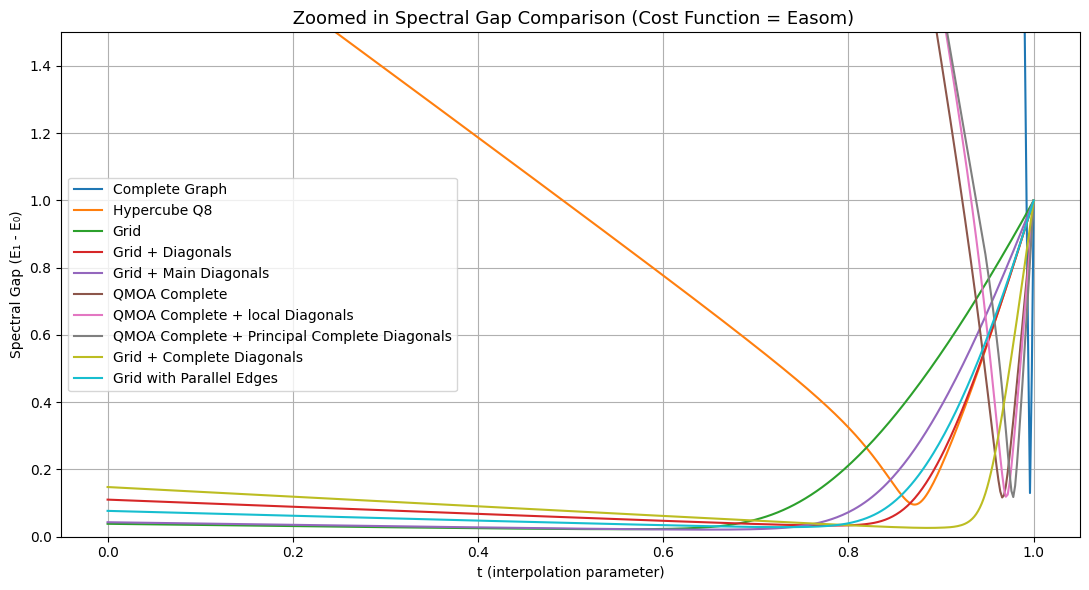

In [20]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    return -np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn,-7*np.pi, 8*np.pi,-7*np.pi, 8*np.pi, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Easom)", fontsize=13)
plt.grid(True)
plt.ylim(0, 1.5)
plt.legend()
plt.tight_layout()
plt.show()

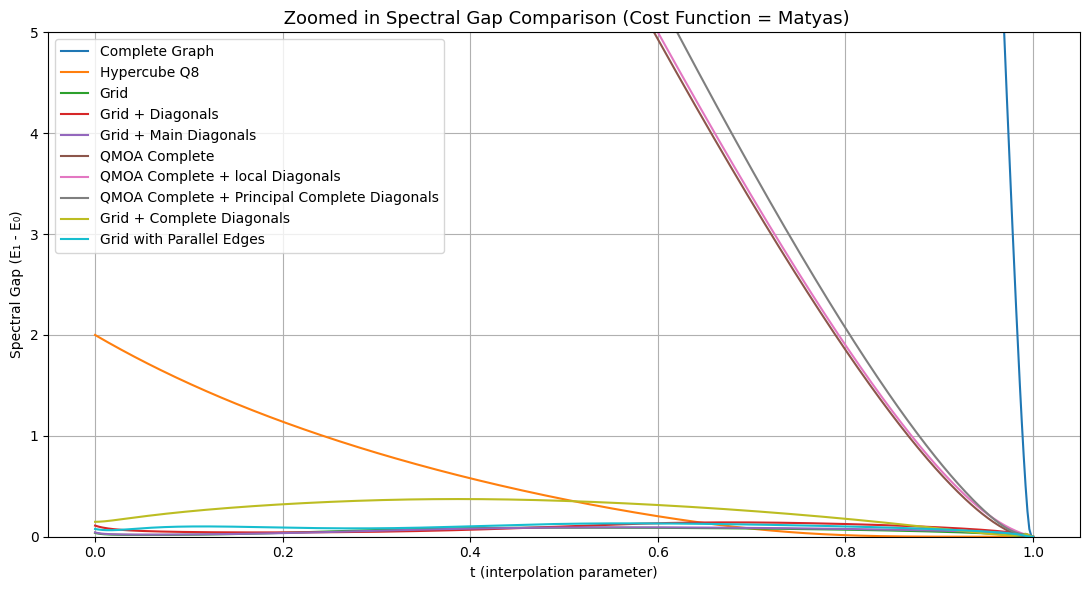

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    return 0.26 * (x**2 + y**2) - 0.48 * x * y


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn,-5, 5, -5, 5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Matyas)", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

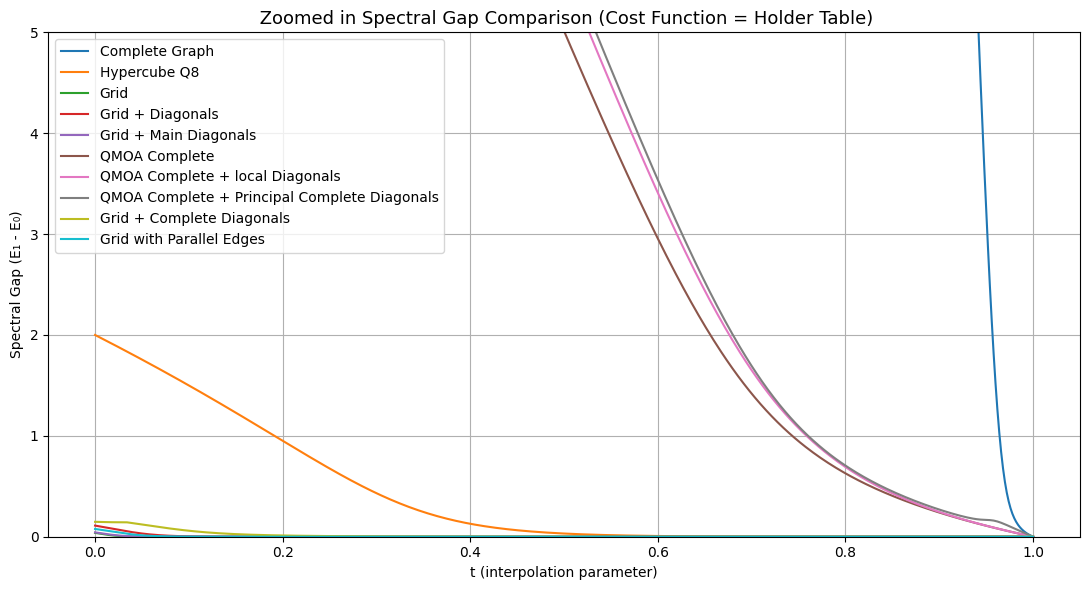

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    r = np.sqrt(x**2 + y**2)
    return -np.abs(np.sin(x) * np.cos(y) * np.exp(np.abs(1 - r/np.pi)))


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn,-10, 10, -10, 10, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Holder Table)", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

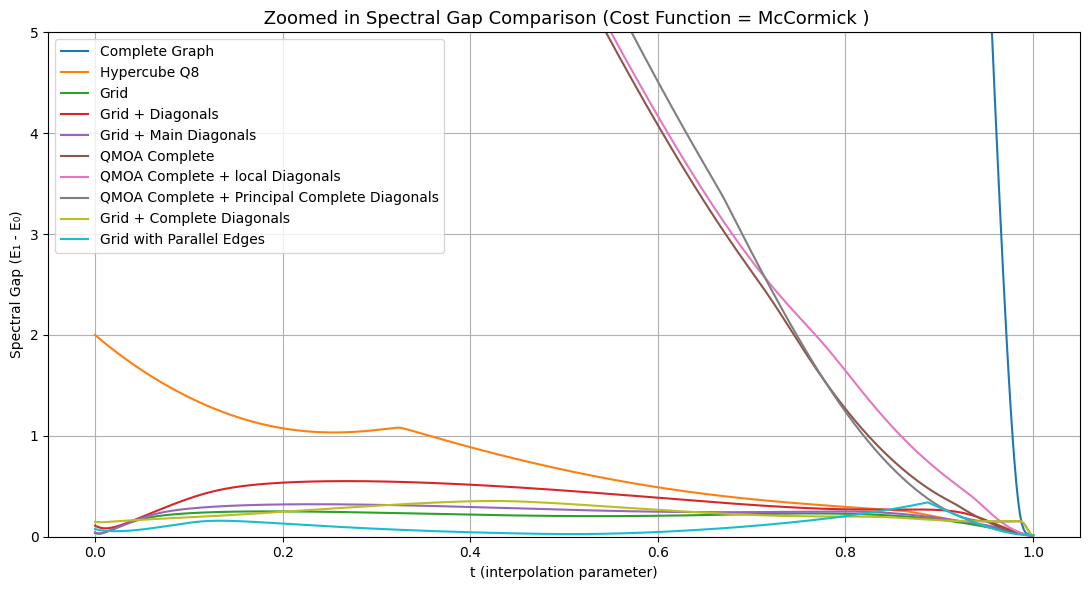

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    return np.sin(x + y) + (x - y)**2 - 1.5*x + 2.5*y + 1.0


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -1.5, 4.0, -3.0, 4.0, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = McCormick )", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

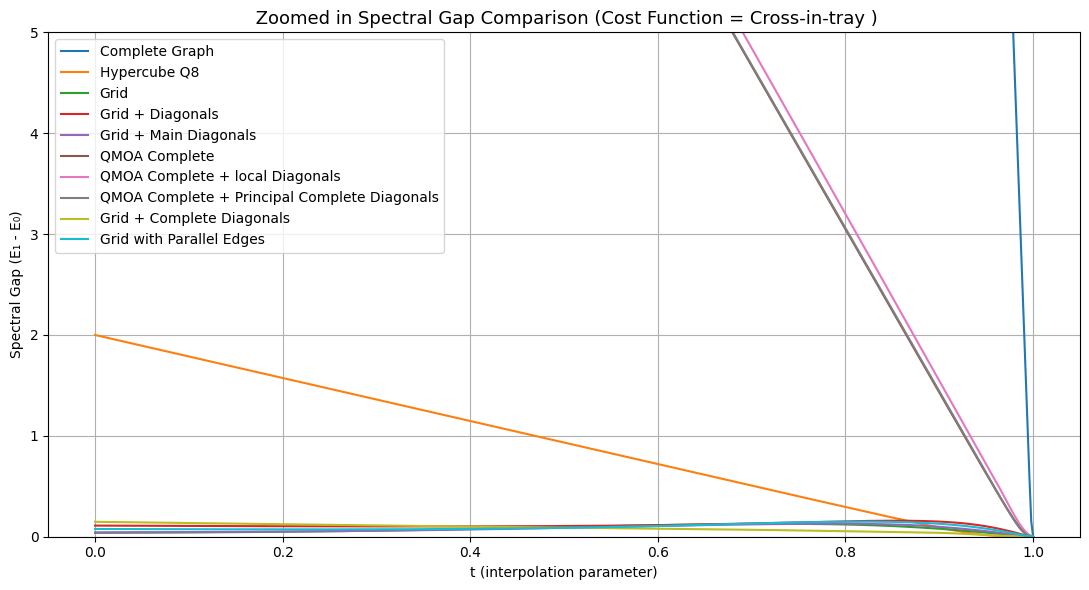

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    x, y = np.asarray(x, dtype=float), np.asarray(y, dtype=float)
    term1 = np.sin(x) * np.sin(y)
    term2 = np.exp(np.abs(100 - (np.sqrt(x**2 + y**2) / np.pi)))
    return -0.0001 * (np.abs(term1 * term2) + 1)**0.1


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -10, 10, -10, 10, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Cross-in-tray )", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

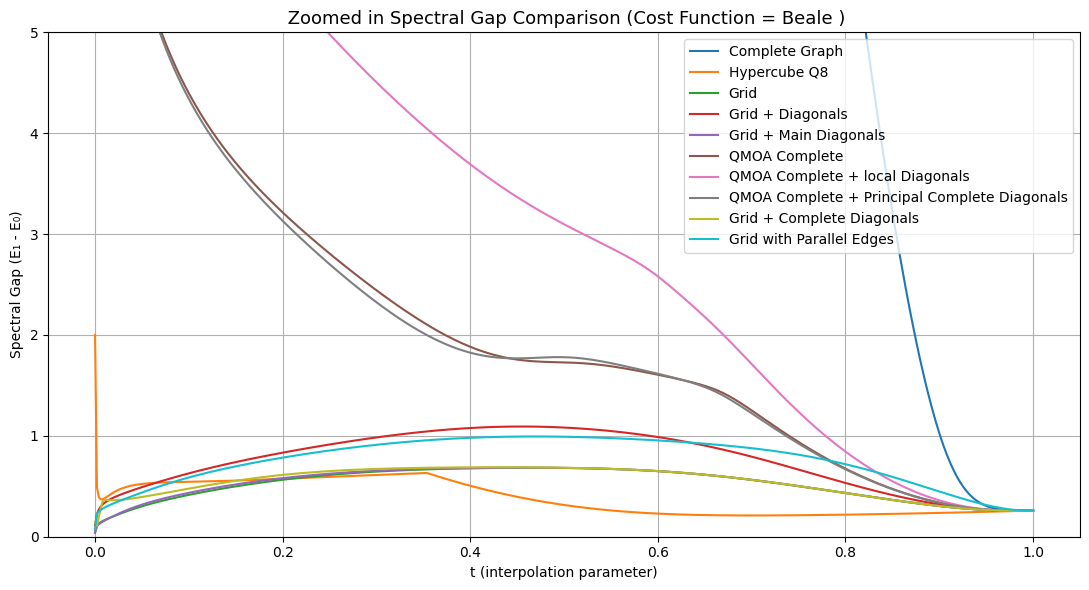

In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    x, y = np.asarray(x, dtype=float), np.asarray(y, dtype=float)
    term1 = (1.5 - x + x*y)**2
    term2 = (2.25 - x + x*y**2)**2
    term3 = (2.625 - x + x*y**3)**2
    return term1 + term2 + term3


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -4.5, 4.5, -4.5, 4.5, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Beale )", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

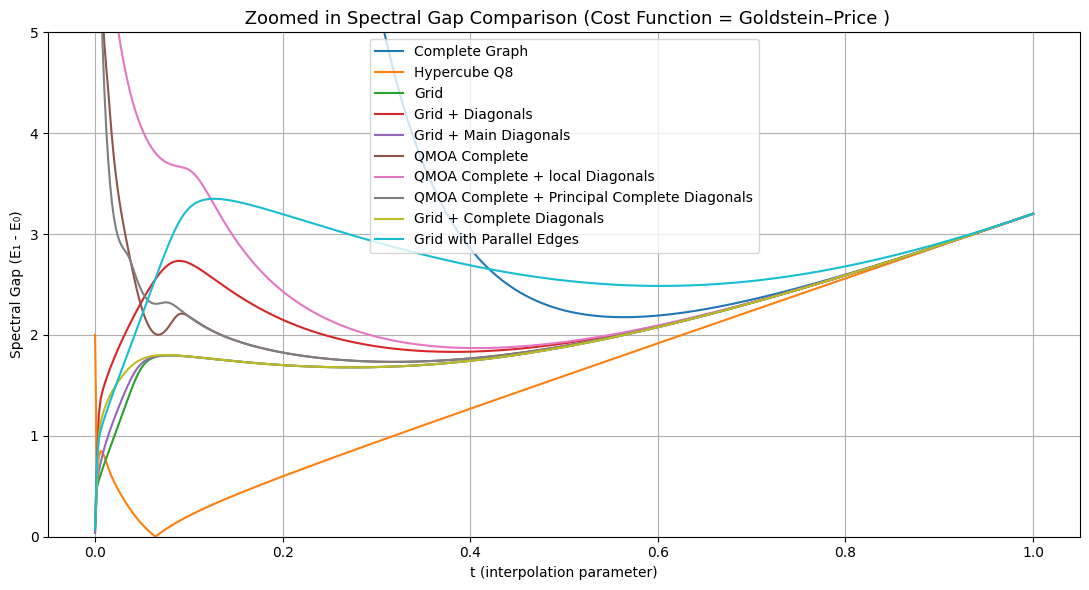

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    x, y = np.asarray(x, dtype=float), np.asarray(y, dtype=float)
    term1 = 1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)
    term2 = 30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2)
    return term1 * term2


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -2, 2, -2, 2, rows, cols)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Goldstein–Price )", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

Discrete minimum value: 0.22222222222222182


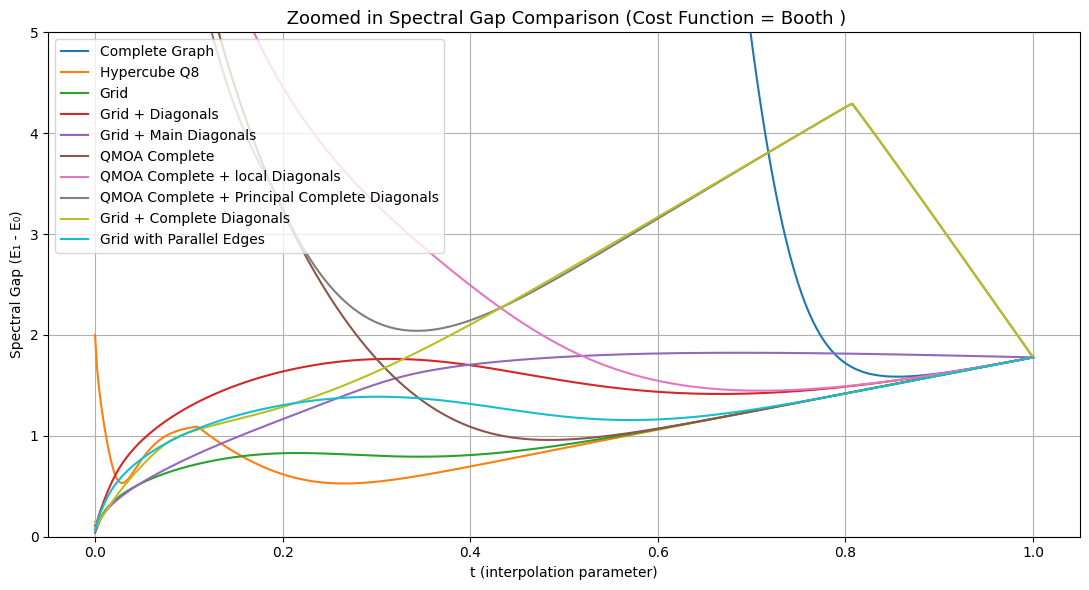

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    x, y = np.asarray(x, dtype=float), np.asarray(y, dtype=float)
    return (x + 2*y - 7)**2 + (2*x + y - 5)**2


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -10, 10, -10, 10, rows, cols)
cost_vals = np.diag(H_C)
min_idx = np.argmin(cost_vals)
print("Discrete minimum value:", cost_vals[min_idx])

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Booth )", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()

Direct gap: 0.0


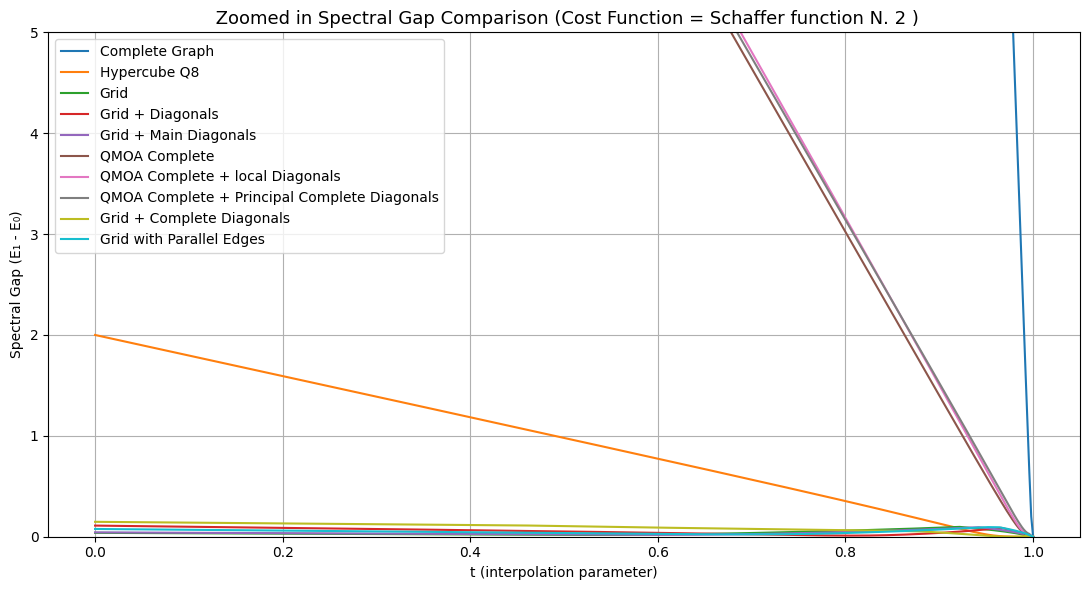

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# === Grid size ===
rows, cols = 16, 16
n = rows * cols  # Number of nodes

# Complex cost function: f(x, y)
def cost_fn(x, y):
    num = np.sin(x**2 - y**2)**2 - 0.5
    den = (1 + 0.001*(x**2 + y**2))**2
    return 0.5 + num / den


def build_cost_hamiltonian(cost_func, x_min, x_max, y_min, y_max, rows, cols):
    dx = (x_max - x_min) / (rows - 1)
    dy = (y_max - y_min) / (cols - 1)

    costs = []
    for i in range(rows):
        for j in range(cols):
            x = x_min + i * dx
            y = y_min + j * dy
            costs.append(cost_func(x, y))
    return np.diag(costs)

# Build H_C diagonal using correct domain
H_C = build_cost_hamiltonian(cost_fn, -10, 10, -10, 10, rows, cols)
#The smallest function value we found on our discretized grid
cost_vals = np.diag(H_C)
sorted_vals = np.sort(cost_vals)
direct_gap = sorted_vals[1]-sorted_vals[0]
print("Direct gap:", direct_gap)

# === Spectral gap computation ===
def compute_spectral_gap(G):
    G = nx.convert_node_labels_to_integers(G)
    H_Q = nx.laplacian_matrix(G).todense().astype(float)
    assert H_Q.shape == H_C.shape

    t_vals = np.linspace(0, 1, 500)
    gap_vals = []

    for t in t_vals:
        H_t = (1 - t) * H_Q + t * H_C
        eigvals = eigh(H_t, eigvals_only=True)
        gap_vals.append(eigvals[1] - eigvals[0])
    return t_vals, gap_vals

# === Graph Constructors ===

def build_grid(rows, cols):
    return nx.convert_node_labels_to_integers(nx.grid_2d_graph(rows, cols))

def build_grid_with_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))
            G.add_edge((i + 1, j), (i, j + 1))
    return nx.convert_node_labels_to_integers(G)

def build_grid_with_main_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)
    for i in range(min(rows - 1, cols - 1)):
        G.add_edge((i, i), (i + 1, i + 1))
        G.add_edge((i, cols - 1 - i), (i + 1, cols - 2 - i))
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_complete(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    return nx.convert_node_labels_to_integers(G)

def build_qmoa_with_diagonals(rows, cols):
    G = nx.Graph()
    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))
    # All-to-all in rows
    for r in range(rows):
        row_nodes = [(r, c) for c in range(cols)]
        for i in range(len(row_nodes)):
            for j in range(i + 1, len(row_nodes)):
                G.add_edge(row_nodes[i], row_nodes[j])
    # All-to-all in columns
    for c in range(cols):
        col_nodes = [(r, c) for r in range(rows)]
        for i in range(len(col_nodes)):
            for j in range(i + 1, len(col_nodes)):
                G.add_edge(col_nodes[i], col_nodes[j])
    # Add diagonals
    for i in range(rows - 1):
        for j in range(cols - 1):
            G.add_edge((i, j), (i + 1, j + 1))  # Forward diagonal
            G.add_edge((i + 1, j), (i, j + 1))  # Backward diagonal

    # Relabel nodes to 0...n-1 to match H_C
    return nx.convert_node_labels_to_integers(G, ordering="sorted")
def build_qmoa_with_principal_complete_diagonals(rows, cols):
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c))

    # Row-wise complete connections
    for r in range(rows):
        row = [(r, c) for c in range(cols)]
        for i in range(len(row)):
            for j in range(i + 1, len(row)):
                G.add_edge(row[i], row[j])

    # Column-wise complete connections
    for c in range(cols):
        col = [(r, c) for r in range(rows)]
        for i in range(len(col)):
            for j in range(i + 1, len(col)):
                G.add_edge(col[i], col[j])

    # Principal main diagonal (↘)
    main_diag = [(i, i) for i in range(min(rows, cols))]
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Principal anti-diagonal (↙)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_grid_with_complete_diagonals(rows, cols):
    G = nx.grid_2d_graph(rows, cols)

    # Collect nodes along the main diagonal (top-left to bottom-right)
    main_diag = [(i, i) for i in range(min(rows, cols))]

    # Collect nodes along the anti-diagonal (top-right to bottom-left)
    anti_diag = [(i, cols - 1 - i) for i in range(min(rows, cols))]

    # Add complete edges among all nodes on main diagonal
    for i in range(len(main_diag)):
        for j in range(i + 1, len(main_diag)):
            G.add_edge(main_diag[i], main_diag[j])

    # Add complete edges among all nodes on anti-diagonal
    for i in range(len(anti_diag)):
        for j in range(i + 1, len(anti_diag)):
            G.add_edge(anti_diag[i], anti_diag[j])

    return nx.convert_node_labels_to_integers(G)

def build_multigraph_grid(rows, cols, edge_multiplicity=2):
    G = nx.MultiGraph()
    for i in range(rows):
        for j in range(cols):
            if j < cols - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i, j + 1))
            if i < rows - 1:
                for _ in range(edge_multiplicity):
                    G.add_edge((i, j), (i + 1, j))
    return G

def multigraph_to_weighted_graph(G_multi):
    G_weighted = nx.Graph()
    for u, v in G_multi.edges():
        if G_weighted.has_edge(u, v):
            G_weighted[u][v]['weight'] += 1
        else:
            G_weighted.add_edge(u, v, weight=1)
    return nx.convert_node_labels_to_integers(G_weighted)

# === Graph Definitions ===
graphs = {
    "Complete Graph": nx.complete_graph(n),
    "Hypercube Q8": nx.convert_node_labels_to_integers(nx.hypercube_graph(8)),
    "Grid": build_grid(rows, cols),
    "Grid + Diagonals": build_grid_with_diagonals(rows, cols),
    "Grid + Main Diagonals": build_grid_with_main_diagonals(rows, cols),
    "QMOA Complete": build_qmoa_complete(rows, cols),
    "QMOA Complete + local Diagonals": build_qmoa_with_diagonals(rows, cols),
    "QMOA Complete + Principal Complete Diagonals": build_qmoa_with_principal_complete_diagonals(rows, cols),
    "Grid + Complete Diagonals" : build_grid_with_complete_diagonals(rows, cols)
}

# Add weighted version of multiedge grid
G_multi_raw = build_multigraph_grid(rows, cols, edge_multiplicity=2)
G_multi_weighted = multigraph_to_weighted_graph(G_multi_raw)
graphs["Grid with Parallel Edges"] = G_multi_weighted

# === Plot spectral gaps ===
plt.figure(figsize=(11, 6))
for name, G in graphs.items():
    if len(G.nodes) != n:
        print(f"Skipping {name}: node count mismatch ({len(G.nodes)} ≠ {n})")
        continue
    t_vals, gap_vals = compute_spectral_gap(G)
    plt.plot(t_vals, gap_vals, label=name)

plt.xlabel("t (interpolation parameter)")
plt.ylabel("Spectral Gap (E₁ - E₀)")
plt.title(" Zoomed in Spectral Gap Comparison (Cost Function = Schaffer function N. 2 )", fontsize=13)
plt.grid(True)
plt.ylim(0, 5)
plt.legend()
plt.tight_layout()
plt.show()